In [9]:
# FOLDER PATHS
# period 1 exams
I_mon1 = "data/enrolment-data-cleaned-2024-period-I/MondayOct14-900-1200"
I_mon2 = "data/enrolment-data-cleaned-2024-period-I/MondayOct14-1300-1600"
I_tue = "data/enrolment-data-cleaned-2024-period-I/TuesdayOct15"
I_wed = "data/enrolment-data-cleaned-2024-period-I/WednesdayOct16"
I_thu = "data/enrolment-data-cleaned-2024-period-I/ThursdayOct17"

# period 2 exams
II_mon1 = "data/enrolment-data-cleaned-2024-period-II/Monday-2-12_cleaned"
II_mon2 = "data/enrolment-data-cleaned-2024-period-II/Monday-9-12_cleaned"
II_tue1 = "data/enrolment-data-cleaned-2024-period-II/Tuesday-3-12-900_cleaned"
II_tue2 = "data/enrolment-data-cleaned-2024-period-II/Tuesday-3-12-1630_cleaned"
II_tue3 = "data/enrolment-data-cleaned-2024-period-II/Tuesday-10-12_cleaned"
II_wed = "data/enrolment-data-cleaned-2024-period-II/Wednesday-11-12_cleaned"
II_thu1 = "data/enrolment-data-cleaned-2024-period-II/Thursday-5-12_cleaned"
II_thu2 = "data/enrolment-data-cleaned-2024-period-II/Thursday-12-12-900_cleaned"
II_thu3 = "data/enrolment-data-cleaned-2024-period-II/Thursday-12-12-1630_cleaned"


In [10]:
# Imports
import os
from collections import defaultdict

import pandas as pd
import numpy as np

import pyoptinterface as poi
from pyoptinterface import gurobi

from matplotlib import pyplot as plt


# Constants
EXAM_DATA_FOLDER = I_wed
SUPERVISOR_COST = 16 # average hourly cost of hiring one exam supervisor
EXAM_DURATION_HOURS = 4 # 3-hour-exams + 1 hour buffer for reservations/working hours
RESERVED_HALLS = ['A (Aalto)', 'A1', 'U2 (Mellin)']

course_counts = defaultdict(int)

for filename in os.listdir(EXAM_DATA_FOLDER):
    if filename.endswith('.csv'):
        course_code = filename[:5]
        file_path = os.path.join(EXAM_DATA_FOLDER, filename)
        df = pd.read_csv(file_path)
        confirmed_count = (df['ENROLMENT STATUS'] == 'Confirmed').sum()
        course_counts[course_code] += confirmed_count


n_courses = len(course_counts)
n_students = sum(course_counts.values())
print("Courses:",n_courses, "   Students:", n_students)
epsilon2_values = list(range(0, n_students, 25)) + [int(n_students)]
print(epsilon2_values)
epsilon3_values = np.linspace(0, n_courses*7, 8).tolist()
print(epsilon3_values)


Courses: 5    Students: 1139
[0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000, 1025, 1050, 1075, 1100, 1125, 1139]
[0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0]


In [11]:
def load_course_participation(folder_path):
    course_counts = defaultdict(int)

    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            course_code = filename[:5]
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)
            confirmed_count = (df['ENROLMENT STATUS'] == 'Confirmed').sum()
            course_counts[course_code] += confirmed_count


    return pd.DataFrame(list(course_counts.items()), columns=['Course Code', 'Confirmed Count'])


def process_hall_sheet(df):
    halls_summary = []

    for hall in df['Sali'].unique():
        hall_data = df[df['Sali'] == hall]

        odd_rows = hall_data[hall_data['Rivinro salissa'] % 2 == 1]
        even_rows = hall_data[hall_data['Rivinro salissa'] % 2 == 0]
        total_odd_seats = odd_rows['Tenttipaikkoja rivillä'].sum()
        total_even_seats = even_rows['Tenttipaikkoja rivillä'].sum()

        halls_summary.append({
            'Hall': hall,
            'Odd_row_seats': total_odd_seats,
            'Even_row_seats': total_even_seats
        })

    return pd.DataFrame(halls_summary)

def load_hall_data(file_path):
    sheet1 = pd.read_excel(file_path, sheet_name='Exam_halls_1_seat').sort_values('Sali').reset_index(drop=True)
    sheet2 = pd.read_excel(file_path, sheet_name='Exam_halls_2_seat').sort_values('Sali').reset_index(drop=True)

    sheet1['Sali'] = sheet1['Sali'].str.replace('U2 (Mellin)', 'U2')
    sheet2['Sali'] = sheet2['Sali'].str.replace('U2 (Mellin)', 'U2')

    summary_1_seat = process_hall_sheet(sheet1)
    summary_2_seat = process_hall_sheet(sheet2)

    return summary_1_seat.merge(summary_2_seat, on='Hall', suffixes=('_1', '_2'))

def load_row_data(file_path):
    df_1 = pd.read_excel(file_path, sheet_name='Exam_halls_1_seat').sort_values(['Sali', 'Rivinro salissa']).reset_index(drop=True)
    df_2 = pd.read_excel(file_path, sheet_name='Exam_halls_2_seat').sort_values(['Sali', 'Rivinro salissa']).reset_index(drop=True)

    df_1['Sali'] = df_1['Sali'].str.replace('U2 (Mellin)', 'U2')
    df_2['Sali'] = df_2['Sali'].str.replace('U2 (Mellin)', 'U2')

    merged = pd.merge(
        df_1[['Sali', 'Rivinro salissa', 'Tenttipaikkoja rivillä']],
        df_2[['Sali', 'Rivinro salissa', 'Tenttipaikkoja rivillä']],
        on=['Sali', 'Rivinro salissa'],
        suffixes=('_1', '_2')
    )

    # Assign hall index alphabetically
    hall_order = {hall: idx for idx, hall in enumerate(sorted(merged['Sali'].unique()))}
    merged['hall_index'] = merged['Sali'].map(hall_order)

    # Row index within each hall (0-based index)
    merged['row_index'] = merged.groupby('Sali').cumcount()

    # Add total number of rows per hall
    row_counts = merged.groupby('Sali')['Rivinro salissa'].nunique().reset_index()
    row_counts.rename(columns={'Rivinro salissa': 'n_rows'}, inplace=True)
    merged = merged.merge(row_counts, on='Sali')

    # Final DataFrame
    result = merged[['hall_index', 'Sali', 'row_index', 'n_rows', 'Rivinro salissa', 'Tenttipaikkoja rivillä_1', 'Tenttipaikkoja rivillä_2']]
    result.columns = ['hall_index', 'hall_name', 'row_index', 'n_rows', 'row_number', 'seats_1', 'seats_2']

    return result



def set_reserved_halls(hall_seats, reserved_halls):
    """Filters out the halls that are not reserved."""
    filtered_halls = hall_seats[hall_seats['Hall'].isin(reserved_halls)]
    return filtered_halls.sort_values('Hall').reset_index(drop=True)

def combine_courses(course_data, combined_courses, new_course_code):
    """Combine courses into a single course."""
    rows_to_combine = course_data[course_data['Course Code'].isin(combined_courses)]

    total_count = rows_to_combine['Confirmed Count'].sum()

    updated_data = course_data[~course_data['Course Code'].isin(combined_courses)].copy()

    new_row = pd.DataFrame([{
         'Course Code': new_course_code,
         'Confirmed Count': total_count
    }])

    return pd.concat([updated_data, new_row], ignore_index=True).sort_values('Course Code').reset_index(drop=True)


In [12]:
def setup_optimization_model(courses, rows, prices):
    """Set up and solve the optimization problem."""
    model = gurobi.Model()

    # Prepare data
    sup_per_hall = prices["Valvojia salissa"].tolist()
    sup_cost = [c * SUPERVISOR_COST * EXAM_DURATION_HOURS for c in sup_per_hall]
    size = courses["Confirmed Count"].tolist()

    # Calculating total cost
    hall_prices = [n * EXAM_DURATION_HOURS for n in prices["Tilavuokra/h"].tolist()]
    cost = np.add(hall_prices, sup_cost)

    # Indexing
    course_codes = courses["Course Code"].tolist()
    hall_names = rows["hall_name"].unique().tolist()
    n_courses = len(courses)
    n_halls = len(rows['hall_name'].unique())
    n_students = sum(size)

    n_rows = [rows[rows['hall_index'] == h]['row_index'].nunique() for h in range(n_halls)]
    modes = [1,2]

    # Hall capacities
    cap = {}
    for m in modes:
        for h in range(n_halls):
            for r in range(n_rows[h]):
                v = rows[(rows['hall_index'] == h) & (rows['row_index'] == r)][f'seats_{m}'].values
                cap[m, h, r] = int(v[0]) if len(v) > 0 else 0

    # Decision variables
    x = {} # Course assignments to rows
    y = {} # Hall usage
    z = {} # Hall usage by course

    # 1 if course c assigned to row r in hall h
    for m in modes:
        for c in range(n_courses):
            for h in range(n_halls):
                    for r in range(n_rows[h]):
                        x[m,c,h,r] = model.add_variable(name=f"x_{m}_{c}_{h}_{r}", domain=poi.VariableDomain.Binary)

    # 1 if hall h used
    for m in modes:
        for h in range(n_halls):
            y[m, h] = model.add_variable(name=f"y_{m}_{h}", domain=poi.VariableDomain.Binary)

    # 1 if course c has students in hall h
    for c in range(n_courses):
        for h in range(n_halls):
            z[c,h] = model.add_variable(name=f"z_{c}_{h}", domain=poi.VariableDomain.Binary)


    # Adding constrains

    # The capacities of the rows assigned to course c add up at least to the size of course c
    for c in range(n_courses):
        expr = poi.ExprBuilder()
        for h in range(n_halls):
            for r in range(n_rows[h]):
                for m in modes:
                    expr += x[m,c,h,r]*cap[m,h,r]
        expr -= size[c]
        model.add_linear_constraint(expr, poi.ConstraintSense.GreaterEqual, 0)

    # only one course can be assigned to a row
    for h in range(n_halls):
        for r in range(n_rows[h]):
            for m in modes:
                expr = poi.ExprBuilder()
                for c in range(n_courses):
                    expr += x[m,c,h,r]
                expr -= y[m,h]
                model.add_linear_constraint(expr, poi.ConstraintSense.LessEqual, 0)

    # if student from course c is in hall h row r then hall h is used by course c
    for c in range(n_courses):
        for h in range(n_halls):
            for r in range(n_rows[h]):
                for m in modes:
                    expr = x[m,c,h,r] - z[c,h]
                    model.add_linear_constraint(expr, poi.ConstraintSense.LessEqual, 0)

    # bound z, z[c,h] = 1 if only if at least one of x[m,c,h,r] = 1
    for c in range(n_courses):
        for h in range(n_halls):
            expr = poi.ExprBuilder()
            for m in modes:
                for r in range(n_rows[h]):
                    expr += x[m, c, h, r]
            expr -= z[c, h]
            model.add_linear_constraint(expr, poi.ConstraintSense.GreaterEqual, 0)

    # prevent same-course students in adjacent rows
    for c in range(n_courses):
        for h in range(n_halls):
            for r in range(n_rows[h]-1):
                for m in modes:
                    expr = x[m,c,h,r] + x[m,c,h,r+1]
                    model.add_linear_constraint(expr, poi.ConstraintSense.LessEqual, 1)

    # only one seating type in use per hall
    for h in range(n_halls):
        expr = poi.ExprBuilder()
        for m in modes:
            expr += y[m,h]
        model.add_linear_constraint(expr, poi.ConstraintSense.LessEqual, 1)


    return model, {
        'x': x, 'y': y, 'z': z,
        'course_codes': course_codes,
        'hall_names': hall_names,
        'n_courses': n_courses,
        'n_halls': n_halls,
        'cap': cap,
        'cost': cost,
        'hall_prices': hall_prices,
        'sup_cost': sup_cost,
        'participants': size
    }

In [13]:
def optimize_model(courses, rows, prices):

    # Prepare data
    sup_per_hall = prices["Valvojia salissa"].tolist()
    sup_cost = [c * SUPERVISOR_COST * EXAM_DURATION_HOURS for c in sup_per_hall]
    size = courses["Confirmed Count"].tolist()

    # Calculating total cost
    hall_prices = [n * EXAM_DURATION_HOURS for n in prices["Tilavuokra/h"].tolist()]
    cost = np.add(hall_prices, sup_cost)

    # Indexing
    course_codes = courses["Course Code"].tolist()
    hall_names = rows["hall_name"].unique().tolist()
    n_courses = len(courses)
    n_halls = len(rows['hall_name'].unique())
    n_students = sum(size)

    n_rows = [rows[rows['hall_index'] == h]['row_index'].nunique() for h in range(n_halls)]
    modes = [1,2]

    # Hall capacities
    cap = {}
    for m in modes:
        for h in range(n_halls):
            for r in range(n_rows[h]):
                v = rows[(rows['hall_index'] == h) & (rows['row_index'] == r)][f'seats_{m}'].values
                cap[m, h, r] = int(v[0]) if len(v) > 0 else 0


    results = []

    for epsilon2 in epsilon2_values:
        for epsilon3 in epsilon3_values:
            model_i, context_i = setup_optimization_model(courses, rows, prices)
            x = context_i['x']
            y = context_i['y']
            z = context_i['z']

            f1 = poi.ExprBuilder()
            for h in range(n_halls):
                for m in modes:
                    f1 += y[m,h] * cost[h]

            f2 = poi.ExprBuilder()
            for c in range(n_courses):
                for h in range(n_halls):
                    for r in range(n_rows[h]):
                        f2 += cap[2,h,r] * x[2,c,h,r]

            f3 = poi.ExprBuilder()
            for c in range(n_courses):
                for h in range(n_halls):
                    f3 += z[c,h]
                f3 -= 1

            model_i.add_linear_constraint(f2, poi.ConstraintSense.GreaterEqual, epsilon2)
            model_i.add_linear_constraint(f3, poi.ConstraintSense.LessEqual, epsilon3)

            model_i.set_objective(f1, poi.ObjectiveSense.Minimize)

            model_i.set_model_attribute(poi.ModelAttribute.TimeLimitSec, 30.0)

            model_i.optimize()

            status = model_i.get_model_attribute(poi.ModelAttribute.TerminationStatus)
            #print("Status:", status)
            if status == poi.TerminationStatusCode.OPTIMAL:
                obj = model_i.get_model_attribute(poi.ModelAttribute.ObjectiveValue)
                f2_value = 0
                f3_value = 0

                for c in range(n_courses):
                    for h in range(n_halls):
                        f3_value += model_i.get_value(z[c, h])
                        for r in range(n_rows[h]):
                            f2_value += cap[2,h,r] * model_i.get_value(x[2,c,h,r])
                    f3_value -= 1

                results.append({
                    "epsilon2": epsilon2,
                    "epsilon3": epsilon3,
                    "f1": obj,
                    "f2": f2_value,
                    "f3": f3_value
                })
                print(epsilon2, epsilon3, ":", obj, f2_value, f3_value)
            else:
                print(epsilon2, epsilon3, ":", "Optimization failed.")
    return results



In [14]:
# Load and process data
course_data = load_course_participation(EXAM_DATA_FOLDER)
row_data = load_row_data("data/Exam_halls_and_example.xlsx")
price_data = pd.read_excel("data/Exam_halls_and_example.xlsx", sheet_name='Hall_prices').sort_values('Sali').reset_index(drop=True)
# This can be used to set the halls that have been reserved
#set_reserved_halls(hall_data, ['A (Aalto)', 'D', 'E', 'U2'])

# This can be used to combine courses into one
#course_data = combine_courses(course_data, ['A0501','A0502','A0503','A0504'], 'A05XX')

# Set up and solve optimization
results = optimize_model(course_data, row_data, price_data)


0 0.0 : Optimization failed.
0 5.0 : Optimization failed.
0 10.0 : 4458.0 0.0 10.0
0 15.0 : 4458.0 0.0 15.0
0 20.0 : 4458.0 0.0 19.0
0 25.0 : 4458.0 0.0 14.0
0 30.0 : 4458.0 0.0 17.0
0 35.0 : 4458.0 0.0 16.0
25 0.0 : Optimization failed.
25 5.0 : Optimization failed.
25 10.0 : 4583.280000000001 34.0 10.0
25 15.0 : 4583.280000000001 30.0 15.0
25 20.0 : 4583.28 34.0 20.0
25 25.0 : 4583.280000000001 34.0 22.0
25 30.0 : 4583.28 34.0 20.0
25 35.0 : 4583.280000000001 34.0 20.0
50 0.0 : Optimization failed.
50 5.0 : Optimization failed.
50 10.0 : 4658.72 65.0 10.0
50 15.0 : 4658.72 65.0 15.0
50 20.0 : 4658.72 65.0 20.0
50 25.0 : 4658.72 65.0 23.0
50 30.0 : 4658.719999999999 65.0 21.0
50 35.0 : 4658.719999999999 65.0 21.0
75 0.0 : Optimization failed.
75 5.0 : Optimization failed.
75 10.0 : 4663.04 84.0 10.0
75 15.0 : 4662.4 105.0 15.0
75 20.0 : 4662.4 105.0 19.0
75 25.0 : 4662.4 105.0 23.0
75 30.0 : 4662.4 105.0 20.0
75 35.0 : 4662.4 105.0 22.0
100 0.0 : Optimization failed.
100 5.0 : Optimiz

[10, 15, 19, 14, 17, 16, 10, 15, 20, 22, 20, 20, 10, 15, 20, 23, 21, 21, 10, 15, 19, 23, 20, 22, 15, 20, 22, 22, 25, 10, 15, 20, 21, 22, 22, 15, 20, 19, 22, 25, 15, 18, 23, 23, 21, 15, 20, 20, 23, 23, 14, 20, 23, 27, 21, 15, 18, 22, 20, 20, 10, 15, 20, 20, 21, 18, 10, 13, 18, 20, 21, 19, 15, 20, 24, 24, 25, 15, 20, 23, 26, 27, 15, 20, 24, 25, 22, 15, 20, 23, 22, 27, 15, 20, 23, 29, 25, 15, 20, 25, 26, 25, 15, 20, 24, 20, 22, 15, 20, 25, 27, 28, 15, 20, 23, 23, 30, 15, 20, 23, 24, 23, 15, 20, 19, 20, 18, 15, 20, 25, 28, 26, 20, 25, 29, 31, 15, 19, 25, 30, 28, 15, 20, 25, 26, 30, 15, 19, 23, 24, 27, 15, 20, 23, 25, 27, 15, 19, 25, 29, 26, 20, 25, 30, 27, 20, 25, 30, 33, 15, 20, 24, 27, 28, 20, 24, 25, 25, 20, 25, 28, 32, 20, 25, 30, 34, 20, 25, 30, 35, 20, 25, 29, 35, 20, 25, 30, 33, 20, 24, 30, 32, 20, 25, 30, 33, 20, 25, 26, 26, 20, 25, 29, 35, 20, 25, 30, 27, 20, 25, 30, 35, 20, 25, 30, 31]
[0 1 1 0 1 1 0 1 2 2 2 2 0 1 2 2 2 2 0 1 1 2 2 2 1 2 2 2 3 0 1 2 2 2 2 1 2
 1 2 3 1 1 2 2 2 1 2

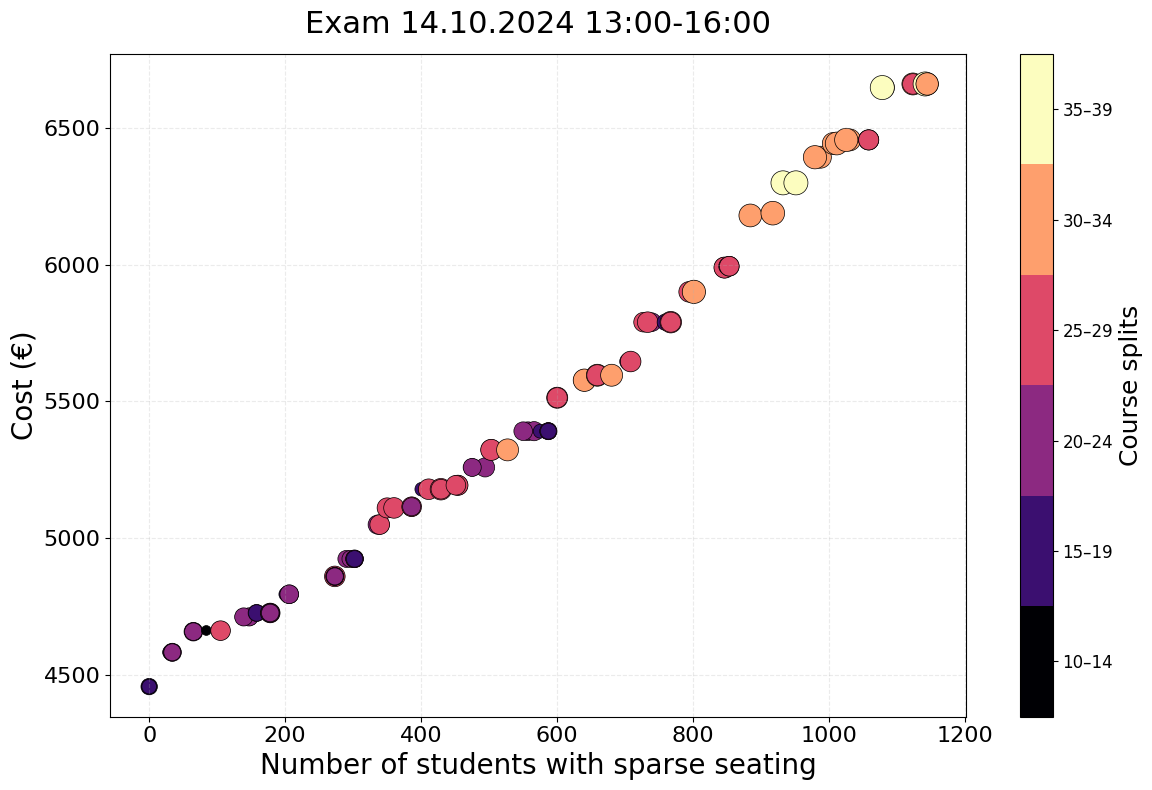

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

f1 = [r['f1'] for r in results]
f2 = [r['f2'] for r in results]
f3 = [r['f3'] for r in results]

f3 = [ round(x) for x in f3 ]

print(f3)
bin_size = 5
min_val = min(f3)
max_val = max(f3)
edges = np.arange(min_val, max_val + bin_size + 1e-8, bin_size)
n_bins = len(edges) - 1
f3_binned = np.digitize(f3, edges) - 1
print(f3_binned)

colors = plt.cm.magma(np.linspace(0, 1, n_bins))
cmap = mcolors.ListedColormap(colors)
norm = mcolors.Normalize(vmin=0, vmax=n_bins - 1)

s_min, s_max = 50, 300
sizes = np.interp(f3, (min(f3), max(f3)), (s_min, s_max))


fig, ax = plt.subplots(figsize=(12, 8))

sc = ax.scatter(
    f2, f1,
    c=f3_binned, cmap=cmap, norm=norm,
    s=sizes, marker='o', edgecolors='black', linewidths=0.5
)

ax.set_ylabel("Cost (€)", fontsize=20)
ax.set_xlabel("Number of students with sparse seating", fontsize=20)
#Exam 16.10.2024 16:30-19:30
#Exam 2.12.2024 9:00-12:00
ax.set_title("Exam 14.10.2024 13:00-16:00", fontsize=22, pad=15)
ax.tick_params(axis='both', labelsize=16)
ax.grid(True, linestyle='--', alpha=0.25)

# --- Colorbar with interval labels
tick_locs = np.arange(0, n_bins)
tick_labels = [f"{int(edges[i])}–{int(edges[i+1])-1}" for i in range(n_bins)]
cbar = plt.colorbar(sc, ax=ax, ticks=tick_locs, spacing='proportional',
                    boundaries=np.arange(-0.5, n_bins + 0.5, 1))
cbar.ax.set_yticklabels(tick_labels, fontsize=12)
cbar.set_label("Course splits", fontsize=18)

plt.tight_layout()
plt.show()


In [16]:
print(results)

[{'epsilon2': 0, 'epsilon3': 10.0, 'f1': 4458.0, 'f2': 0.0, 'f3': 10.0}, {'epsilon2': 0, 'epsilon3': 15.0, 'f1': 4458.0, 'f2': 0.0, 'f3': 15.0}, {'epsilon2': 0, 'epsilon3': 20.0, 'f1': 4458.0, 'f2': 0.0, 'f3': 19.0}, {'epsilon2': 0, 'epsilon3': 25.0, 'f1': 4458.0, 'f2': 0.0, 'f3': 14.0}, {'epsilon2': 0, 'epsilon3': 30.0, 'f1': 4458.0, 'f2': 0.0, 'f3': 17.0}, {'epsilon2': 0, 'epsilon3': 35.0, 'f1': 4458.0, 'f2': 0.0, 'f3': 16.0}, {'epsilon2': 25, 'epsilon3': 10.0, 'f1': 4583.280000000001, 'f2': 34.0, 'f3': 10.0}, {'epsilon2': 25, 'epsilon3': 15.0, 'f1': 4583.280000000001, 'f2': 30.0, 'f3': 15.0}, {'epsilon2': 25, 'epsilon3': 20.0, 'f1': 4583.28, 'f2': 34.0, 'f3': 20.0}, {'epsilon2': 25, 'epsilon3': 25.0, 'f1': 4583.280000000001, 'f2': 34.0, 'f3': 22.0}, {'epsilon2': 25, 'epsilon3': 30.0, 'f1': 4583.28, 'f2': 34.0, 'f3': 20.0}, {'epsilon2': 25, 'epsilon3': 35.0, 'f1': 4583.280000000001, 'f2': 34.0, 'f3': 20.0}, {'epsilon2': 50, 'epsilon3': 10.0, 'f1': 4658.72, 'f2': 65.0, 'f3': 10.0}, {'